In [23]:
# You can edit the font size here to make rendered text more comfortable to read
# It was built on a 13" retina screen with 18px
from IPython.core.display import display, HTML
display(HTML("<style>.rendered_html { font-size: 18px; }</style>"))

In [24]:
%matplotlib notebook
import sys
import os
from collections import Counter, OrderedDict
import numpy as np
from operator import itemgetter
import matplotlib.pyplot as plt
from astropy.table import Table
import schwimmbad
from cesium.time_series import TimeSeries
import cesium.featurize as featurize
from tqdm import tnrange, tqdm_notebook
import sklearn 
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [25]:
pbmap = OrderedDict([(0,'u'), (1,'g'), (2,'r'), (3,'i'), (4, 'z'), (5, 'y')])

# it also helps to have passbands associated with a color
pbcols = OrderedDict([(0,'blueviolet'), (1,'green'), (2,'red'),\
                      (3,'orange'), (4, 'black'), (5, 'brown')])

pbnames = list(pbmap.values())

In [26]:
datadir = 'data/'
metafilename = f'{datadir}/training_set_metadata.csv'
metadata = Table.read(metafilename, format='csv')
nobjects = len(metadata)
#metadata

Since we can split between extragalactic and galactic sources on the basis of redshift, you may choose to build separate classifiers for the two sets. 

Or you might split the deep-drilling fields (DDF i.e. `ddf_bool` = 1) up from the wide-fast-deep fields (WFD i.e. `ddf_bool` = 0). 

You could even try making classifiers for different redshift bins, if you believe some classes will not be present at some redshifts. 

Or you might use that some of the training _and test_ data includes spectroscopic and photometric redshift, and see if you can use that information to derive bias corrections and apply non-linear transformations to the data before processing it.

Because there are definitely biases... 

(Also, if you made this kind of redshift-redshift plot from the test data, you'd see how non-representative the training set was.)

<IPython.core.display.Javascript object>


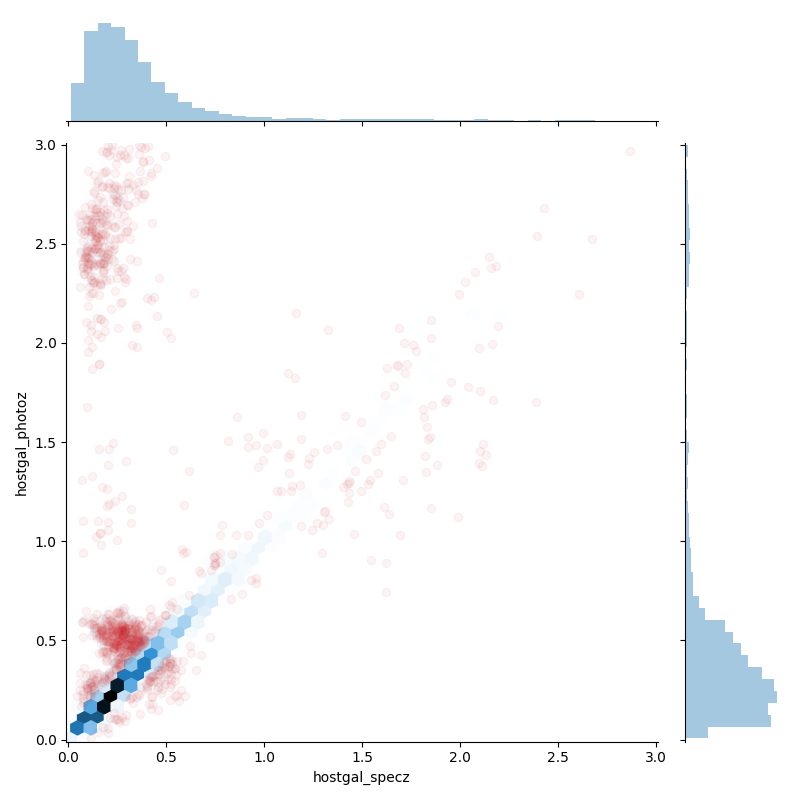

In [27]:
extragal = metadata['hostgal_specz'] != 0.
g = sns.jointplot(metadata['hostgal_specz'][extragal],\
              metadata['hostgal_photoz'][extragal], kind='hex',\
                  xlim=(-0.01, 3.01), ylim=(-0.01,3.01), height=8)

outliers = np.abs(metadata['hostgal_specz'] - metadata['hostgal_photoz']) > 0.1
fig = g.fig
fig.axes[0].scatter(metadata['hostgal_specz'][outliers],\
                    metadata['hostgal_photoz'][outliers], color='C3', alpha=0.05)
fig.tight_layout()

There's many potential choices. 

For now we'll leave everything together.

<IPython.core.display.Javascript object>


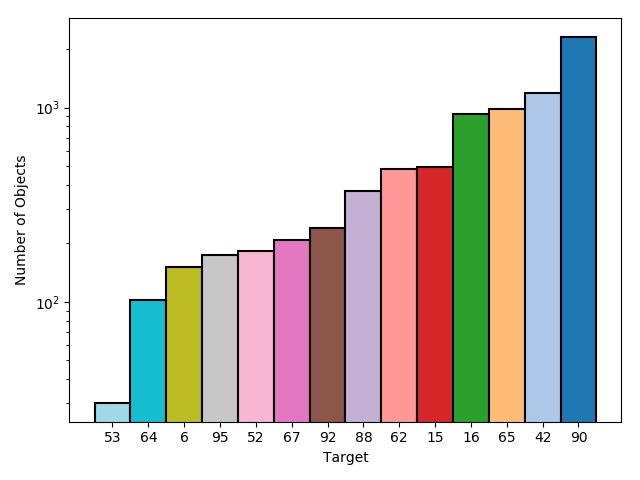

In [28]:
counts = Counter(metadata['target'])
labels, values = zip(*sorted(counts.items(), key=itemgetter(1)))
fig, ax = plt.subplots()

cmap = plt.cm.tab20
nlines = len(labels)
classcolor =  list(cmap(np.linspace(0,1,nlines)))[::-1]

# we'll create a mapping between class and color
classcolmap = dict(zip(labels, classcolor))

indexes = np.arange(nlines)
width = 1
ax.bar(indexes, values, width, edgecolor='k',\
       linewidth=1.5, tick_label=labels, log=True, color=classcolor)
ax.set_xlabel('Target')
ax.set_ylabel('Number of Objects')
fig.tight_layout()

You can see the class distribution in the training set is imbalanced. This reflects reality. The Universe doesn't produce all kinds of events at equal rates, and even if it did, some events are fainter than others, so we'd naturally find fewer of them than bright events.

Next, we'll read the light curve data. All the objects in the training set are in a single file:

In [29]:
lcfilename = f'{datadir}/training_set.csv'
lcdata = Table.read(lcfilename, format='csv')
#lcdata

Next, we'll make a `Timeseries` object using the `cesium` python package for each lightcurve.

In [30]:
tsdict = OrderedDict()
for i in tnrange(nobjects, desc='Building Timeseries'):
    row = metadata[i]
    thisid = row['object_id']
    target = row['target']
    
    meta = {'z':row['hostgal_photoz'],\
            'zerr':row['hostgal_photoz_err'],\
            'mwebv':row['mwebv']}
    
    ind = (lcdata['object_id'] == thisid)
    thislc = lcdata[ind]

    pbind = [(thislc['passband'] == pb) for pb in pbmap]
    t = [thislc['mjd'][mask].data for mask in pbind ]
    m = [thislc['flux'][mask].data for mask in pbind ]
    e = [thislc['flux_err'][mask].data for mask in pbind ]

    tsdict[thisid] = TimeSeries(t=t, m=m, e=e,\
                        label=target, name=thisid, meta_features=meta,\
                        channel_names=pbnames )
    
del lcdata

The list of features available with packages like `cesium` is <a href="http://cesium-ml.org/docs/feature_table.html">huge</a>. We'll only compute a subset now.

In [31]:
features_to_use = ["amplitude",
                   "percent_beyond_1_std",
                   "maximum",
                   "max_slope",
                   "median",
                   "median_absolute_deviation",
                   "percent_close_to_median",
                   "minimum",
                   "skew",
                   "std",
                   "weighted_average"]

In [32]:
# we'll turn off warnings for a bit, because numpy can be whiny. 
import warnings
warnings.simplefilter('ignore')

In [33]:
featurefile = f'{datadir}/plasticc_featuretable.npz'
if os.path.exists(featurefile):
    featuretable, _ = featurize.load_featureset(featurefile)
else:
    print("featuretable not found")
    #to create featuretable use demo nb
            
    featuretable = featurize.assemble_featureset(features_list=features_list,\
                              time_series=tsdict.values())
    featurize.save_featureset(fset=featuretable, path=featurefile)

In [34]:
old_names = featuretable.columns.values
new_names = ['{}_{}'.format(x, pbmap.get(y,'meta')) for x,y in old_names]
cols = [featuretable[col] for col in old_names]
allfeats = Table(cols, names=new_names)
del featuretable

In [35]:
splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=42)
splits = list(splitter.split(allfeats, metadata['target']))[0]
train_ind, test_ind = splits

<IPython.core.display.Javascript object>


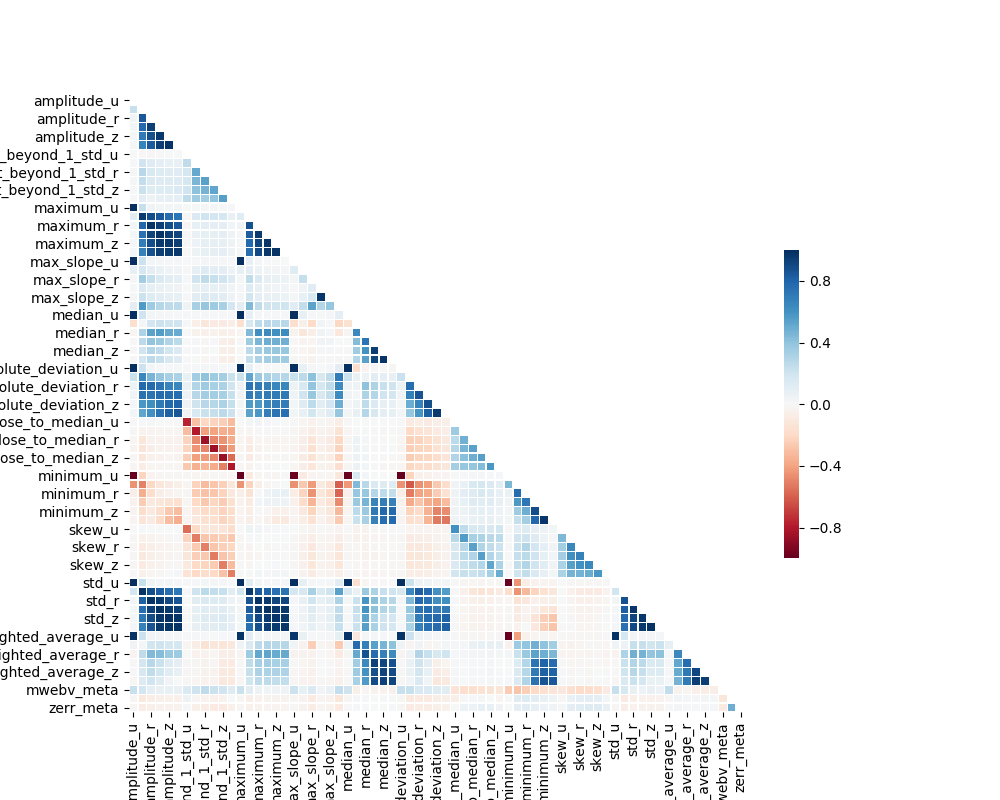

In [36]:
corr = allfeats.to_pandas().corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
fig, ax = plt.subplots(figsize=(10, 8))

# Draw the heatmap with the mask and correct aspect ratio
corr_plot = sns.heatmap(corr, mask=mask, cmap='RdBu', center=0,
                square=True, linewidths=.2, cbar_kws={"shrink": .5})

You can see some of the bands are strongly correlated with each other, so lets try to reduce the dimensionality of the dataset looking for a two effective passbands.

In [37]:
Xtrain = np.array(allfeats[train_ind].as_array().tolist())
Ytrain = np.array(metadata['target'][train_ind].tolist())

Xtest  = np.array(allfeats[test_ind].as_array().tolist())
Ytest  = np.array(metadata['target'][test_ind].tolist())

In [38]:
ncols = len(new_names)
npca  = (ncols  - 3)//len(pbnames)  + 3

In [39]:
pca = PCA(n_components=npca, whiten=True, svd_solver="full", random_state=42)
Xtrain_pca = pca.fit_transform(Xtrain)
Xtest_pca = pca.transform(Xtest)

<IPython.core.display.Javascript object>


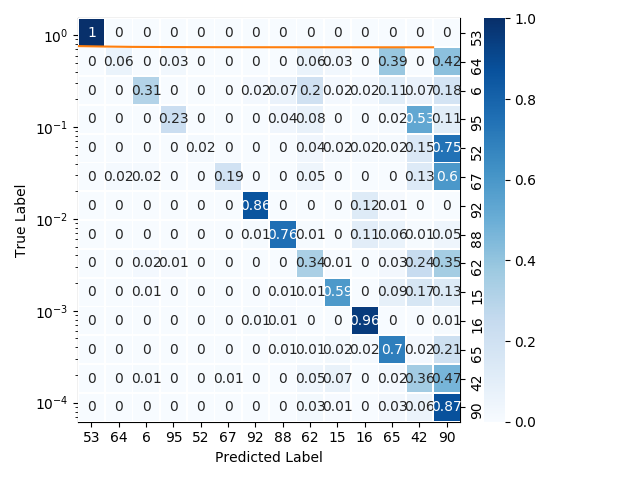

In [40]:
fig, ax = plt.subplots()
ax.plot(np.arange(npca), pca.explained_variance_ratio_, color='C0')
ax2 = ax.twinx()
ax2.plot(np.arange(npca), np.cumsum(pca.explained_variance_ratio_), color='C1')
ax.set_yscale('log')
ax.set_xlabel('PCA Component')
ax.set_ylabel('Explained Variance Ratio')
ax2.set_ylabel('Cumulative Explained Ratio')
fig.tight_layout()

Looks like a few features seem to hold all the weight! You might think to yourself that this is trivial! Lets build a simple classifier - we'll use a random forest here, but you can switch this out for whatever you like.

In [41]:
clf = RandomForestClassifier(n_estimators=200, criterion='gini',\
                       oob_score=True, n_jobs=-1, random_state=42,\
                      verbose=1, class_weight='balanced', max_features='sqrt')

Now let's apply the classifier to the data:

In [42]:
clf.fit(Xtrain_pca, Ytrain)
Ypred = clf.predict(Xtest_pca)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    0.6s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.0s finished


In [43]:
1-len((Ytest-Ypred).nonzero()[0])/len(Ytest)

0.6535031847133759

In [44]:
cm = confusion_matrix(Ytest, Ypred, labels=labels)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
annot = np.around(cm, 2)

Which we can plot up...

In [45]:
## fig, ax = plt.subplots(figsize=(9,7))
sns.heatmap(cm, xticklabels=labels, yticklabels=labels, cmap='Blues', annot=annot, lw=0.5)
ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')
ax.set_aspect('equal')

Ooer... Some classes seem to be easy to pick out. Others are being confused very badly. This reflects what happens in reality to astronomers. Some classes are easier to distinguish than others. 

You can also see the performance (or lack thereof) on the test data if you like.

Lets also define the metric for the contest:

In [46]:
def plasticc_log_loss(y_true, y_pred, relative_class_weights=None):
        """
        Implementation of weighted log loss used for the Kaggle challenge
        """
        predictions = y_pred.copy()

        # sanitize predictions
        epsilon = sys.float_info.epsilon # this is machine dependent but essentially prevents log(0)
        predictions = np.clip(predictions, epsilon, 1.0 - epsilon)
        predictions = predictions / np.sum(predictions, axis=1)[:, np.newaxis]

        predictions = np.log(predictions)
        # multiplying the arrays is equivalent to a truth mask as y_true only contains zeros and ones
        class_logloss = []
        for i in range(predictions.shape[1]):
            # average column wise log loss with truth mask applied
            result = np.average(predictions[:, i][y_true[:, i] == 1])
            class_logloss.append(result)
        return -1 * np.average(class_logloss, weights=relative_class_weights)
    

In [47]:
# we didn't release the weights with the contest at Kaggle's request
# they have been probed through the leaderboard though
# we leave the reader to adjust this as they see fit
# the official metric is always what is on Kaggle's leaderboard. 
# This notebook is solely for demonstration.
weights = np.ones(nlines)


# we want the actual prediction probabilities
Ypred = clf.predict_proba(Xtest_pca)

# we also need to express the truth table as a matrix
sklearn_truth = np.zeros((len(Ytest), nlines))
label_index_map = dict(zip(clf.classes_, np.arange(nlines)))
for i, x in enumerate(Ytest):
    sklearn_truth[i][label_index_map[Ytest[i]]] = 1
 
      
logloss = plasticc_log_loss(sklearn_truth, Ypred, relative_class_weights=weights)
print("LogLoss: {:.3f}".format(logloss))

LogLoss: 2.166


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.0s finished


Again, find us on the Kaggle forums if you have questions we can answer.

Good luck!

# Deep Learning First try

In [48]:
import torch
import torch.utils.data
import torch.nn as nn
import torch.nn.functional as F

In [49]:
Xtrain = np.array(allfeats[train_ind].as_array().tolist())
Ytrain = np.array(metadata['target'][train_ind].tolist())

Xtest  = np.array(allfeats[test_ind].as_array().tolist())
Ytest  = np.array(metadata['target'][test_ind].tolist())

display(Xtrain.shape, Ytrain.shape, Xtest.shape, Ytest.shape)

# map target values, e.g. 90->1...
for j, y in enumerate([Ytrain, Ytest]):
    unique_y = np.unique(y)
    class_map = dict()
    for i,val in enumerate(unique_y):
        class_map[val] = i

    y_map = np.zeros((y.shape[0],))
    if j == 0:
        Ytrain = np.array([class_map[val] for val in y])
    else:
        Ytest = np.array([class_map[val] for val in y])
Ytest, Ytrain, Ytrain[list(np.where(Ytrain == 14)[0])] # no class 14 in training set

(5493, 69)

(5493,)

(2355, 69)

(2355,)

(array([1, 3, 3, ..., 4, 4, 9]),
 array([11,  3, 11, ...,  2,  8,  9]),
 array([], dtype=int64))

<IPython.core.display.Javascript object>


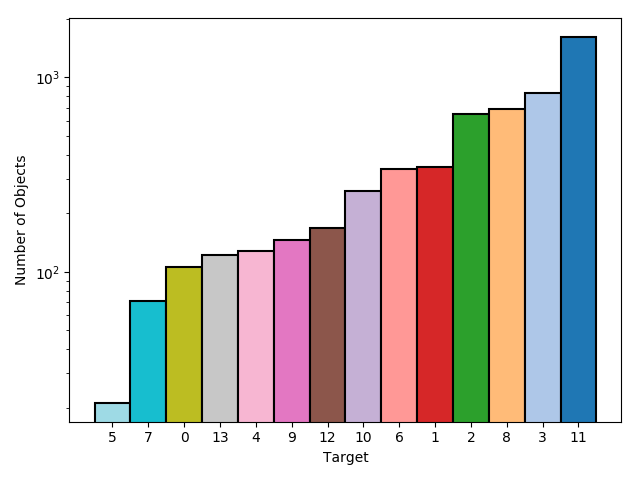

In [50]:
counts = Counter(Ytrain)
labels, values = zip(*sorted(counts.items(), key=itemgetter(1)))
fig, ax = plt.subplots()

cmap = plt.cm.tab20
nlines = len(labels)
classcolor =  list(cmap(np.linspace(0,1,nlines)))[::-1]

# we'll create a mapping between class and color
classcolmap = dict(zip(labels, classcolor))

indexes = np.arange(nlines)
width = 1
ax.bar(indexes, values, width, edgecolor='k',\
       linewidth=1.5, tick_label=labels, log=True, color=classcolor)
ax.set_xlabel('Target')
ax.set_ylabel('Number of Objects')
fig.tight_layout()

In [60]:
import torch.utils.data as data_utils

XtrainTensor, YtrainTensor  = torch.Tensor(Xtrain),torch.Tensor(Ytrain)
XtestTensor, YtestTensor = torch.Tensor(Xtest),torch.Tensor(Ytest)

train = data_utils.TensorDataset(XtrainTensor, YtrainTensor)
train_loader = data_utils.DataLoader(train, batch_size=16, shuffle=True)
test = data_utils.TensorDataset(XtestTensor, YtestTensor)
test_loader = data_utils.DataLoader(test)

In [51]:
# the Classifier stolen from Pytorch Tutorial

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # 2 fully connected layers
        
        self.fc1 = nn.Linear(69,36)
        self.fc2 = nn.Linear(36,15)
        

    def forward(self, x):
        # Max pooling over a (2, 2) window
        #x = F.max_pool2d(F.relu(self.conv1(x)), 2)
        # If the size is a square you can only specify a single number
        
        # Flatten 2d array to pass to linear layer, -1 works for arbitrary #rows which can vary with batchsize
        #x = x.view(-1, self.num_flat_features(x))
        
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features
    
    prediction_list = []
    def predict(self, dataloader):
        for i, batch in enumerate(dataloader):
            pred, output = self.forward(batch)
            prediction_list.append(pred.cpu())
        return prediction_list


net = Net()
print(net)

Net(
  (fc1): Linear(in_features=69, out_features=36, bias=True)
  (fc2): Linear(in_features=36, out_features=15, bias=True)
)


In [62]:
# training
import torch.optim as optim

# create your optimizer
optimizer = optim.SGD(net.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

In [63]:
for epoch in range(100):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, sample in enumerate(train_loader, 0):
        # get the inputs
        inputs, labels = sample

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels.long())
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
    if epoch % 100 == 0:    # print every 2000 mini-batches
        # validation loss
        prediction_list = []
        running_loss_test = 0.0
        for i_test, sample_test in enumerate(test_loader, 0):
            # get the inputs
            inputs_test, labels_test = sample_test

            # zero the parameter gradients
            optimizer.zero_grad()

            outputs_test = net(inputs_test)
            loss_test = criterion(outputs_test, labels_test.long())
            prediction_list.append(np.argmax(outputs_test.detach().numpy()))
            
            running_loss_test += loss_test.item()
            
        print('[%d, %5d] loss: %.3f validation_loss: %.3f' % \
              (epoch, i, running_loss / (len(train_loader)*100), loss_test/len(test_loader)))
        running_loss = 0.0

print('Finished Training')

[0,   343] loss: 0.214 validation_loss: 0.001
Finished Training


# Accuracy

In [64]:
Ypred = np.array(prediction_list)
{"Accuracy in %": np.round(1-len((Ytest-Ypred).nonzero()[0])/len(Ytest),4)*100}

{'Accuracy in %': 1.91}